# Solving Gonzaga Basketball
By Erick May  

CPSC 322, Fall 2022

## Introduction
The dataset I am using comes from sports-reference.com, and contains basic information and statistics for each Gonzaga men's basketball game from 2010-11 to the present. I will be using the data about each game to predict what the result of the game would be.
### FINDINGS HERE

In [1]:
import importlib
import tabulate
import matplotlib.pyplot as plt
import copy

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation


## Data Analysis
As the website only has individual game data going back to the 2010-11 season, the dataset only contains 430 games. Some attributes that are part of the dataset, but will not be part of our analysis, include an ID, date, school name (always "Gonzaga"), opponent name, and total minutes played by Gonzaga, which will almost always be 200 since 5 players are on the floor at a time for the 40 minutes of the game (or more if it goes into overtime). The attributes of interest for us will be the location of the game (Home, Neutral, or Away) and shooting statistics for each team, which includes the raw numbers (Makes and Attempts) along with percentages for field goals, 2-pointers, 3-pointers, and freethrows. The class to predict will be the result of the game, with 4 labels: L, CloseW, ComfortableW, and BlowoutW. Gonzaga wins so often that wins had to be split up into close wins (10 points or less), comfortable wins (11-19 points) and blowouts (20+ points) to give the class labels a somewhat more even distribution (although far from perfect, as shown below).

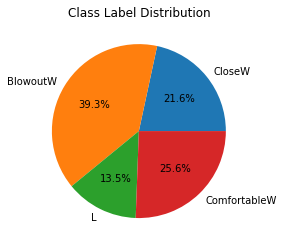

In [2]:
zag_table = myutils.read_table("input_data/gonzaga_games_2010-present.csv")
zag_header = zag_table.pop(0)
X = []
zag_copy = copy.deepcopy(zag_table)
X_numeric = [[row[3], row[7], row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], row[16], row[17], row[18], row[20], row[21], row[22], row[23], row[24], row[25], row[26], row[27], row[28], row[29], row[30], row[31]] for row in zag_copy]
for i in range(1, len(X_numeric[0])):
    col = myutils.get_col(X_numeric, i)
    col_norm, min_val, max_val = myutils.normalize(col)
    for j in range(0, len(X_numeric)):
        X_numeric[j][i] = col_norm[j]
y = []
for row in zag_table:
    row[5] = myutils.determine_class_label(row[19], row[32])
    row[3] = myutils.determine_loc(row[3])
    row[7], row[8], row[9] = myutils.discretize_fgs(row[7], row[8], row[9])
    row[10], row[11], row[12] = myutils.discretize_twos(row[10], row[11], row[12])
    row[13], row[14], row[15] = myutils.discretize_threes(row[13], row[14], row[15])
    row[16], row[17], row[18] = myutils.discretize_fts(row[16], row[17], row[18])
    row[20], row[21], row[22] = myutils.discretize_fgs(row[20], row[21], row[22])
    row[23], row[24], row[25] = myutils.discretize_twos(row[23], row[24], row[25])
    row[26], row[27], row[28] = myutils.discretize_threes(row[26], row[27], row[28])
    row[29], row[30], row[31] = myutils.discretize_fts(row[29], row[30], row[31])
    X.append([row[3], row[7], row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], row[16], row[17], row[18], row[20], row[21], row[22], row[23], row[24], row[25], row[26], row[27], row[28], row[29], row[30], row[31]])
    y.append(row[5])

X_header = [zag_header[3], zag_header[7], zag_header[8], zag_header[9], zag_header[10], zag_header[11], zag_header[12], zag_header[13], zag_header[14], zag_header[15], zag_header[16], zag_header[17], zag_header[18], zag_header[20], zag_header[21], zag_header[22], zag_header[23], zag_header[24], zag_header[25], zag_header[26], zag_header[27], zag_header[28], zag_header[29], zag_header[30], zag_header[31]]
class_label = zag_header[5]
classes, class_counts = myutils.find_col_frequencies(y)
plt.figure()
plt.title("Class Label Distribution")
plt.pie(class_counts, labels=classes, autopct="%1.1f%%")
plt.show()

Figure 1 shows the distribution of the class labels I concocted.
### MORE SUMMARY STATS AND GRAPHS HERE

## Classification Results
### CLASSIFICATION DESCRIPTION HERE

In [3]:
train_test_strat_indices = myevaluation.stratified_kfold_split(X, y, 10, 0)

In [4]:
nb_accuracy_sum, nb_precision_sum, nb_recall_sum, nb_f1_sum = 0, 0, 0, 0
nb_matrix_sum = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
knn_accuracy_sum, knn_precision_sum, knn_recall_sum, knn_f1_sum = 0, 0, 0, 0
knn_matrix_sum = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
dumb_accuracy_sum, dumb_precision_sum, dumb_recall_sum, dumb_f1_sum = 0, 0, 0, 0
dumb_matrix_sum = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
tree_accuracy_sum, tree_precision_sum, tree_recall_sum, tree_f1_sum = 0, 0, 0, 0
tree_matrix_sum = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

for i in range (0, 10):
    X_train = [X[index] for index in train_test_strat_indices[i][0]]
    y_train = [y[index] for index in train_test_strat_indices[i][0]]
    X_test = [X[index] for index in train_test_strat_indices[i][1]]
    y_test = [y[index] for index in train_test_strat_indices[i][1]]
    X_train_numeric = [X_numeric[index] for index in train_test_strat_indices[i][0]]
    X_test_numeric = [X_numeric[index] for index in train_test_strat_indices[i][1]]

    nb_clf = MyNaiveBayesClassifier()
    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)
    nb_accuracy_sum += myevaluation.accuracy_score(y_test, y_pred)
    nb_precision_sum += myevaluation.binary_precision_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    nb_recall_sum += myevaluation.binary_recall_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    nb_f1_sum += myevaluation.binary_f1_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    confusing_matrix = myevaluation.confusion_matrix(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"])
    for i in range(0, len(confusing_matrix)):
        for j in range(0, len(confusing_matrix[i])):
            nb_matrix_sum[i][j] += confusing_matrix[i][j]

    knn_clf = MyKNeighborsClassifier()
    knn_clf.fit(X_train_numeric, y_train)
    y_pred = knn_clf.predict(X_test_numeric)
    knn_accuracy_sum += myevaluation.accuracy_score(y_test, y_pred)
    knn_precision_sum += myevaluation.binary_precision_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    knn_recall_sum += myevaluation.binary_recall_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    knn_f1_sum += myevaluation.binary_f1_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    confusing_matrix = myevaluation.confusion_matrix(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"])
    for i in range(0, len(confusing_matrix)):
        for j in range(0, len(confusing_matrix[i])):
            knn_matrix_sum[i][j] += confusing_matrix[i][j]

    dumb_clf = MyDummyClassifier()
    dumb_clf.fit(X_train, y_train)
    y_pred = dumb_clf.predict(X_test)
    dumb_accuracy_sum += myevaluation.accuracy_score(y_test, y_pred)
    dumb_precision_sum += myevaluation.binary_precision_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    dumb_recall_sum += myevaluation.binary_recall_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    dumb_f1_sum += myevaluation.binary_f1_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    confusing_matrix = myevaluation.confusion_matrix(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"])
    for i in range(0, len(confusing_matrix)):
        for j in range(0, len(confusing_matrix[i])):
            dumb_matrix_sum[i][j] += confusing_matrix[i][j]

    tree_clf = MyDecisionTreeClassifier()
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)
    tree_accuracy_sum += myevaluation.accuracy_score(y_test, y_pred)
    tree_precision_sum += myevaluation.binary_precision_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    tree_recall_sum += myevaluation.binary_recall_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    tree_f1_sum += myevaluation.binary_f1_score(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"], "L")
    confusing_matrix = myevaluation.confusion_matrix(y_test, y_pred, ["L", "CloseW", "ComfortableW", "BlowoutW"])
    for i in range(0, len(confusing_matrix)):
        for j in range(0, len(confusing_matrix[i])):
            tree_matrix_sum[i][j] += confusing_matrix[i][j]


In [5]:
nb_accuracy = nb_accuracy_sum / 10
nb_error = 1 - nb_accuracy
nb_precision = nb_precision_sum / 10
nb_recall = nb_recall_sum / 10
nb_f1 = nb_f1_sum / 10
print("Naive-Bayes Metrics (Averages for 10-Fold Cross Validation)")
print("-----------------------------------------------------------")
print("accuracy = " + str(nb_accuracy) + ", error rate = " + str(nb_error))
print("precision = " + str(nb_precision) + ", recall = " + str(nb_recall))
print("f1 score: " + str(nb_f1))
print("confusion matrix:")
print(tabulate.tabulate(nb_matrix_sum))

Naive-Bayes Metrics (Averages for 10-Fold Cross Validation)
-----------------------------------------------------------
accuracy = 0.5929572035074021, error rate = 0.4070427964925979
precision = 0.7966666666666666, recall = 0.6300000000000001
f1 score: 0.6937590187590188
confusion matrix:
--  --  --  ---
32  18   7    1
 9  52  27    5
 2  30  45   33
 0   6  37  126
--  --  --  ---


In [6]:
knn_accuracy = knn_accuracy_sum / 10
knn_error = 1 - knn_accuracy
knn_precision = knn_precision_sum / 10
knn_recall = knn_recall_sum / 10
knn_f1 = knn_f1_sum / 10
print("kNN Metrics (Averages for 10-Fold Cross Validation)")
print("---------------------------------------------------")
print("accuracy = " + str(knn_accuracy) + ", error rate = " + str(knn_error))
print("precision = " + str(knn_precision) + ", recall = " + str(knn_recall))
print("f1 score: " + str(knn_f1))
print("confusion matrix:")
print(tabulate.tabulate(knn_matrix_sum))

kNN Metrics (Averages for 10-Fold Cross Validation)
---------------------------------------------------
accuracy = 0.5612096780134216, error rate = 0.4387903219865784
precision = 0.7464285714285714, recall = 0.5549999999999999
f1 score: 0.6266056166056165
confusion matrix:
--  --  --  ---
26  20  11    1
 9  39  39    6
 1  27  53   29
 0  10  36  123
--  --  --  ---


In [7]:
dumb_accuracy = dumb_accuracy_sum / 10
dumb_error = 1 - dumb_accuracy
dumb_precision = dumb_precision_sum / 10
dumb_recall = dumb_recall_sum / 10
dumb_f1 = dumb_f1_sum / 10
print("Dummy Metrics (Averages for 10-Fold Cross Validation)")
print("-----------------------------------------------------------")
print("accuracy = " + str(dumb_accuracy) + ", error rate = " + str(dumb_error))
print("precision = " + str(dumb_precision) + ", recall = " + str(dumb_recall))
print("f1 score: " + str(dumb_f1))
print("confusion matrix:")
print(tabulate.tabulate(dumb_matrix_sum))

Dummy Metrics (Averages for 10-Fold Cross Validation)
-----------------------------------------------------------
accuracy = 0.39308409023383495, error rate = 0.606915909766165
precision = 0.0, recall = 0.0
f1 score: 0.0
confusion matrix:
-  -  -  ---
0  0  0   58
0  0  0   93
0  0  0  110
0  0  0  169
-  -  -  ---


In [8]:
tree_accuracy = tree_accuracy_sum / 10
tree_error = 1 - tree_accuracy
tree_precision = tree_precision_sum / 10
tree_recall = tree_recall_sum / 10
tree_f1 = tree_f1_sum / 10
print("Decision Tree Metrics (Averages for 10-Fold Cross Validation)")
print("-----------------------------------------------------------")
print("accuracy = " + str(tree_accuracy) + ", error rate = " + str(tree_error))
print("precision = " + str(tree_precision) + ", recall = " + str(tree_recall))
print("f1 score: " + str(tree_f1))
print("confusion matrix:")
print(tabulate.tabulate(tree_matrix_sum))
tree_clf.print_decision_rules(X_header, class_label)

Decision Tree Metrics (Averages for 10-Fold Cross Validation)
-----------------------------------------------------------
accuracy = 0.4654978600525963, error rate = 0.5345021399474037
precision = 0.5133333333333333, recall = 0.28
f1 score: 0.33002164502164505
confusion matrix:
--  --  --  ---
15  38   3    2
16  43  18   16
 9  37  27   37
 6  13  35  115
--  --  --  ---
IF Tm_FG == Average AND Opp_FG == Average AND Tm_3P == Average AND Tm_FG% == Average AND Tm_FTA == Average THEN Result == ComfortableW
IF Tm_FG == Average AND Opp_FG == Average AND Tm_3P == Average AND Tm_FG% == Average AND Tm_FTA == High AND Opp_3P == Average THEN Result == ComfortableW
IF Tm_FG == Average AND Opp_FG == Average AND Tm_3P == Average AND Tm_FG% == Average AND Tm_FTA == High AND Opp_3P == High THEN Result == CloseW
IF Tm_FG == Average AND Opp_FG == Average AND Tm_3P == Average AND Tm_FG% == Average AND Tm_FTA == High AND Opp_3P == Low THEN Result == BlowoutW
IF Tm_FG == Average AND Opp_FG == Average AND